# QFT

In [26]:
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.circuit.library import U1Gate, UnitaryGate
from qiskit.visualization import *
from qiskit_aer import *
import qiskit.quantum_info as qi


import numpy as np
from math import pi,log2,sqrt


# For sparse matrices
from scipy import linalg
from scipy.sparse import *

#For continued fractions
from fractions import Fraction  


# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Choosing local simulation to run circuits
service = QiskitRuntimeService(channel="local")

## Phase rotation
We will need the phase rotation to implement the conditional B gate.

If our QFT has size $Q$, we are going to need the conditional phase rotation of angle $\omega$, the $Q$-th root of unit, $\omega=e^{i\frac{2\pi}{Q}}$. Also, the phase rotations of the succesive squaring of that angle.

Here we define the gate ```R(phi)``` to be the  **controlled** phase rotation for $e^{i\phi}$. Hence, we would implement the phase rotation of $\omega$ by ```R(2*pi/Q)```.

To use ```R``` we need to specify the control qubit and the target qubit, like in ```circuit.append(R(alpha),[control,target])```

In [44]:
def R(phi):
    return U1Gate(phi).control(1)

## Recursive construction of QFT

Now, write a function that recursively constructs the QFT circuit of size $Q=2^q$.

Remember that QISKIT is little-endian and our class notes are big-endian, so you will need to invert the order from class notes diagrams.

In [45]:
def QFT(Q):
    if (Q & (Q - 1)) != 0:
        raise ValueError("Q must be a power of 2.")
    
    q = int(log2(Q))
    output = QuantumCircuit(q)

    for i in range(q - 1, -1, -1): # Iterate over the qubits in reverse order
        output.h(i) # Apply a Hadamard gate to the i-th qubit.

        for j in range(i - 1, -1, -1):
            angle = 2 * pi / (2 ** (i - j + 1))  # Apply controlled rotation gates (R) to the i-th qubit, controlled by the j-th qubit.
            output.append(R(angle), [j, i])

    for i in range(q // 2):
        output.swap(i, q - i - 1)   # Swap the qubits to reverse their order, as required by the QFT.

    return output

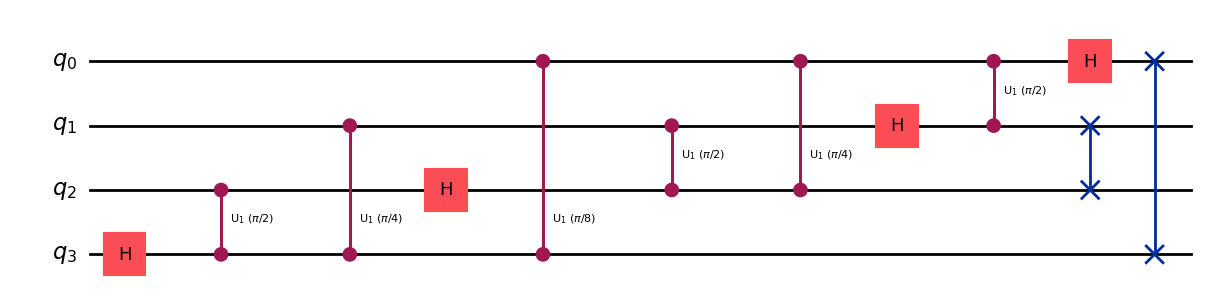

In [46]:
QFT(16).draw(output='mpl')

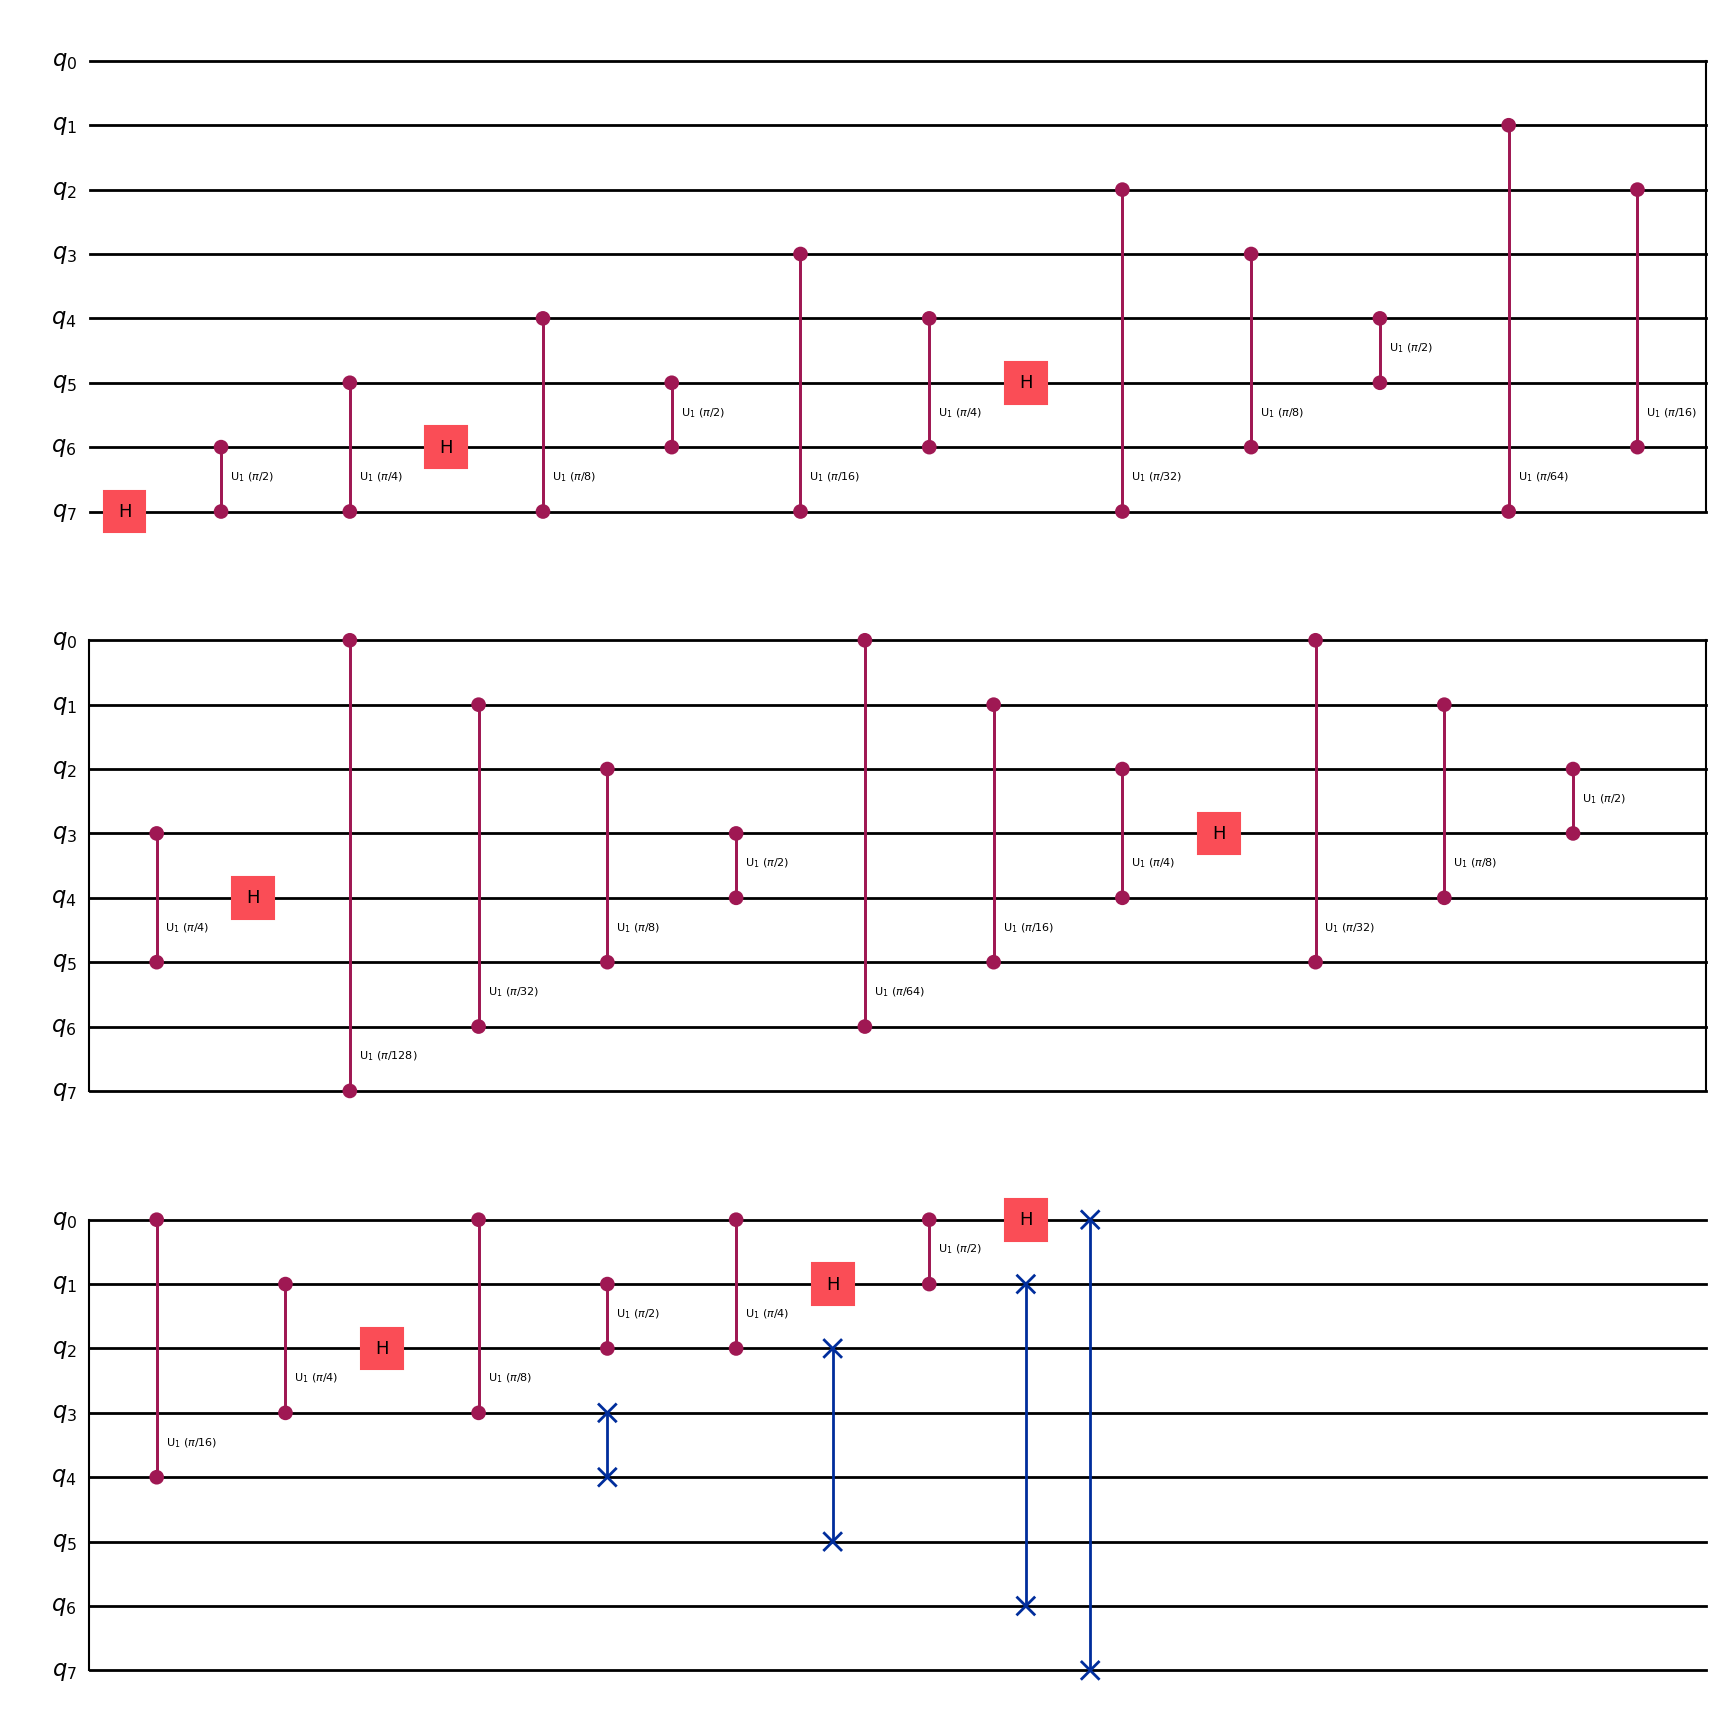

In [47]:
QFT(256).draw(output='mpl')

You can check if the right matrices are computed by checking the value of
```array_to_latex(sqrt(Q)*qi.Operator(QFT(Q)))``` for different values of $Q=2^q$.

In [6]:
array_to_latex(2*qi.Operator(QFT(4)))

<IPython.core.display.Latex object>

In [7]:
array_to_latex(2*sqrt(2)*qi.Operator(QFT(8)))

<IPython.core.display.Latex object>

## Oracle and test
To check that QFT is working properly, let us compute the period of some modular power function.

Unfortunately, factoring even $15=3\cdot 5$ needs $Q=256$, and that in turn needs $q=8$ qubits for input of the oracle function (and $8$ additional qubits for output). The oracle would then be a $16$ qubit unitary, that is a $65536\times 65536$ matrix. This can make things very lengthy...

Instead, let us compute the Quantum Fourier Transform of the function $f(k)=3^k \mod 7$, so that $N=7$. You can use the modular power function ```pow(3,k,7)``` and build the XOR oracle associated to it (in a similar way of what we did for Simon's algorithm oracle).

The size in the oracle in this case comes from $Q=64>49=7^2$, so that $q=6$.

To speedup the function a little bit, we and set the option ```check_input=False```(one that we are sure that our oracle is in fact unitary)

In [8]:
def ket_reg(n,x):
    if x < 0 or x > 2**n-1:
        return(-1)
    output = [[0] for i in range(x)]+[[1]]+ [[0] for i in range(2**n-x-1)]
    return(np.int8(np.matrix(output)))

def bra_reg(n,x):
    return(np.int8(ket_reg(n,x).H))

def Shor_Oracle(x, N):
    q = int(2 * np.log(N) / np.log(2)) + 1  # Necessary number of qubits
    print("You will need " + str(q) + " qubits")
    
    dim = 4**q  # Size of the unitary matrix
    unitary = np.zeros((dim, dim), dtype=np.int8)
    
    for i in range(2**q):
        for j in range(2**q):
            unitary += np.kron(ket_reg(q, j ^ pow(x, i, N)) @ bra_reg(q, j), ket_reg(q, i) @ bra_reg(q, i)) # Unitary matrix for the oracle (remember qiskit is Little Endian)
    
    return UnitaryGate(unitary, label='U_f', check_input = False)


In [9]:
Shor_Gate = Shor_Oracle(3,7)

You will need 6 qubits


Use the ```Shor_Gate``` oracle to build a ```Shor``` circuit (you will need 12 qubits) that:
- Does a total superposition of the "input" qubits
- applies the oracle
- applies the QFT to the "input" qubits
- and measures them

In [10]:
def Shor_Circuit (q, Gate):
    
    total_qubits = 2 * q
    circuit = QuantumCircuit(total_qubits, q)
    
    for i in range(q):
        circuit.h(i)  #Apply Hadamards to create superposition of all possible states

    circuit.append(Gate, range(total_qubits)) # Apply the oracle

    circuit.measure(range(q,2*q), range(q)) # Measure output qubits of the oracle

    QFT_gate = QFT(2**q).to_gate()
    QFT_gate.name = "QFT" + str(q)

    circuit.append(QFT_gate, range(q))  # Apply QFT to the input qubits

    circuit.measure(range(q), range(q)) # Measure output of QFT

    return circuit


Shor = Shor_Circuit (6, Shor_Gate)  # Create Shor circuit with 6 qubits, because for N = 7 we need 6 input qubits

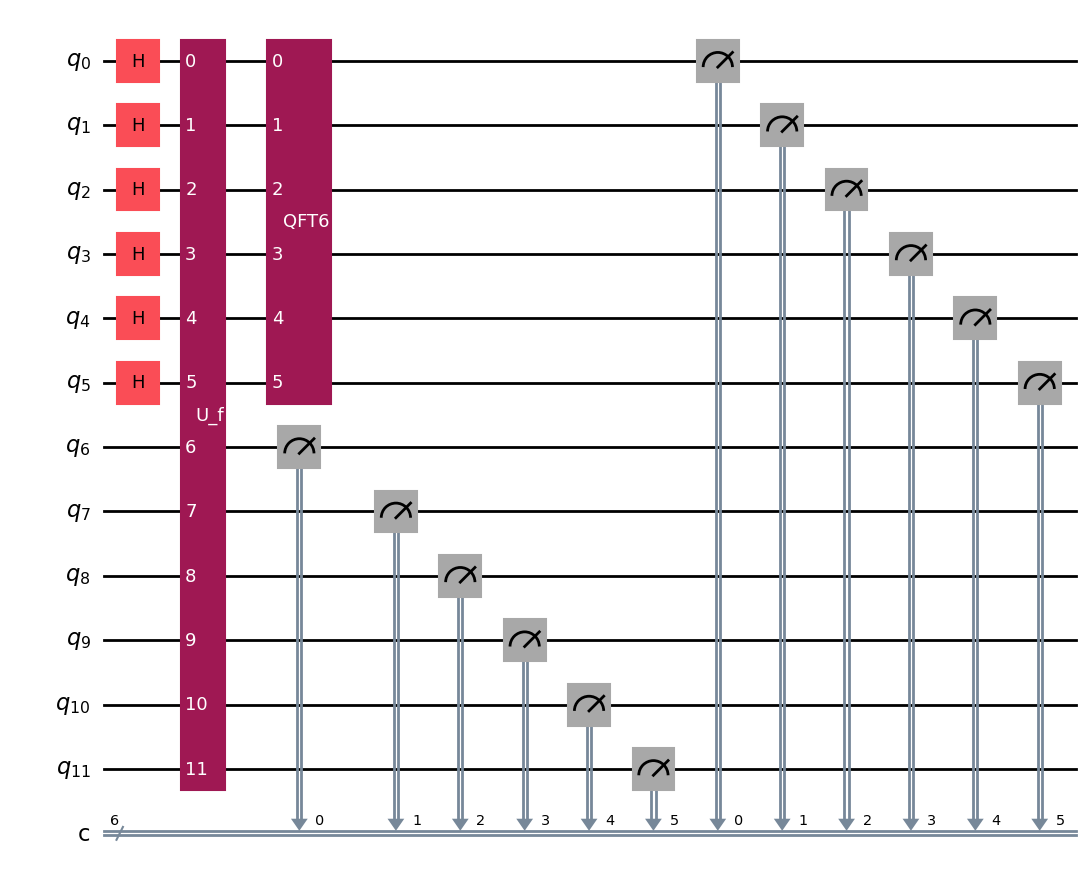

In [11]:
Shor.draw(output = 'mpl')

Let us get a histogram of the circuit. Can you compute the period of our modular power function?

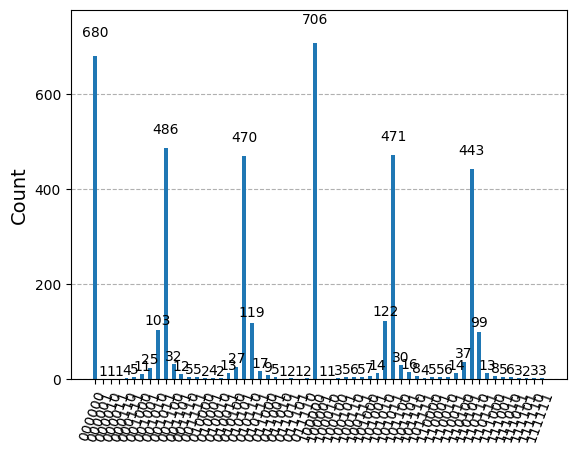

In [12]:
simulator = Aer.get_backend('aer_simulator')
circuit = transpile(Shor, simulator)
result = simulator.run(circuit,shots=4096).result()
statistics = result.get_counts()
plot_histogram(statistics)

Here, we can observe that quantum interference is occurring. By analyzing the histogram, we notice that for specific values of k, such as k = 10, k = 20, k = 31, k = 41 and k = 51, the probability amplitudes constructively interfere, resulting in higher peaks.

If we take Q = 2^6 = 64, we can calculate the period s as it follows:

- k = Q/s -> s = 64/10 = 6,4
- k = 2Q/s -> s = 2*64/20 = 6,4
- k = 3Q/s -> s = 3*64/31 = 6,19
- k = 4Q/s -> s = 4*64/41 = 6,24
- k = 5Q/s -> s = 5*64/51 = 6,27

From these calculations, we can conclude that the period s is aproximately 6.